In [2]:
%cd /private/home/pfz/07-segmark/2404-dev

import os
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio
from videoseal.losses.dwt import DWTForward, DWTInverse

def imshow(img, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375]):
    img = img * torch.tensor(pixel_std).view(3, 1, 1) + torch.tensor(pixel_mean).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/private/home/pfz/07-segmark/2404-dev


/private/home/pfz/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TEsts yuv

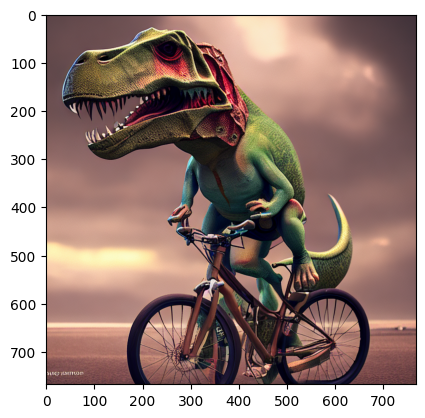

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


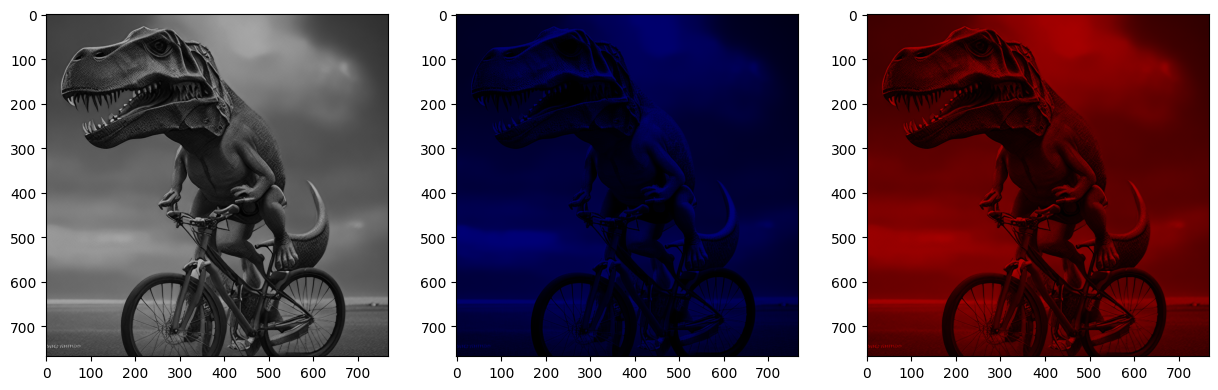

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


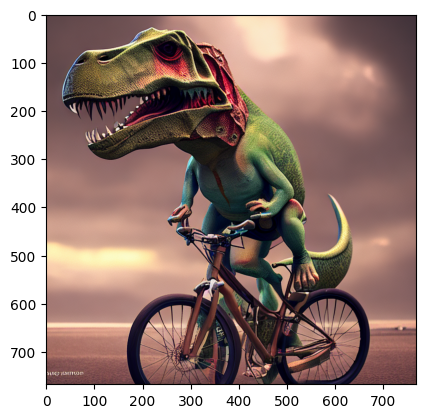

In [53]:
to_tensor = transforms.ToTensor()
default_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
normalize_img = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
unnormalize_img = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]),
])

def torch_to_np(img_tensor):
    img_tensor = unnormalize_img(img_tensor).clamp(0, 1)
    img_tensor = img_tensor.squeeze().permute(1, 2, 0).cpu()
    return img_tensor.numpy()

def rgb_to_yuv(img):
    M = torch.tensor([[0.299, 0.587, 0.114],
                      [-0.14713, -0.28886, 0.436],
                      [0.615, -0.51499, -0.10001]], dtype=torch.float32).to(img.device)
    img = img.permute(0, 2, 3, 1)  # b h w c
    yuv = torch.matmul(img, M)
    yuv = yuv.permute(0, 3, 1, 2)
    return yuv

def yuv_to_rgb(img):
    M = torch.tensor([[1.0, 0.0, 1.13983],
                      [1.0, -0.39465, -0.58060],
                      [1.0, 2.03211, 0.0]], dtype=torch.float32).to(img.device)
    img = img.permute(0, 2, 3, 1)  # b h w c
    rgb = torch.matmul(img, M)
    rgb = rgb.permute(0, 3, 1, 2)
    return rgb


# print(os.listdir("/private/home/pfz/_images"))
img = "/private/home/pfz/_images/trex_bike.png"
img = Image.open(img, "r").convert("RGB")

img_pt = to_tensor(img).unsqueeze(0).repeat(16, 1, 1, 1)
plt.imshow(img_pt[0].permute(1, 2, 0).numpy())
plt.show()

img_yuv = rgb_to_yuv(img_pt)

lum = img_yuv.clone()[0]
lum = lum[0:1, :, :].repeat(3, 1, 1)
blue = img_yuv.clone()[0]
blue[0:2, :, :] = 0
red = img_yuv.clone()[0]
red[1:3, :, :] = 0

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(lum.squeeze().permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 3, 2)
plt.imshow(blue.squeeze().permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 3, 3)
plt.imshow(red.squeeze().permute(1, 2, 0).cpu().numpy())
plt.show()

plt.imshow(yuv_to_rgb(img_yuv)[0].squeeze().permute(1, 2, 0).cpu().numpy())
plt.show()

### Tests torch DWT

In [ ]:
# Define the transformations
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

# Check the images in the directory
print(os.listdir("/private/home/pfz/_images"))

# Load the image
img_path = "/private/home/pfz/_images/chao.png"
img = Image.open(img_path).convert("RGB")

# Convert image to tensor
img_pt = to_tensor(img).unsqueeze(0)

# Display the original image
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [ ]:
def sum_pooling_2x2_stride_1(input_tensor):
    """
    Args:
        input_tensor (torch.Tensor): Input tensor of shape (b, c, h, w)
    Returns:
        torch.Tensor: Tensor after 2x2 sum pooling with stride 1
    """
    padded_input = F.pad(input_tensor, (1, 0, 1, 0), mode='reflect')
    kernel = torch.ones((3, 1, 2, 2), dtype=input_tensor.dtype, device=input_tensor.device)
    pooled_output = F.conv2d(padded_input, kernel, stride=1, padding=0, groups=input_tensor.size(1))
    return pooled_output

def local_variance_2x2_stride_1(input_tensor):
    """
    Args:
        input_tensor (torch.Tensor): Input tensor of shape (b, c, h, w)
    Returns:
        torch.Tensor: Tensor with the local variance computed in each 2x2 window with stride 1
    """
    padded_input = F.pad(input_tensor, (1, 0, 1, 0), mode='reflect')
    kernel = torch.ones((3, 1, 2, 2), dtype=input_tensor.dtype, device=input_tensor.device)
    sum_2x2 = F.conv2d(padded_input, kernel, stride=1, padding=0, groups=input_tensor.size(1))
    sum_of_squares_2x2 = F.conv2d(padded_input ** 2, kernel, stride=1, padding=0, groups=input_tensor.size(1))
    mean_2x2 = sum_2x2 / 4.0
    mean_of_squares_2x2 = sum_of_squares_2x2 / 4.0
    local_variance = mean_of_squares_2x2 - mean_2x2 ** 2
    return local_variance

def get_I(Yh, k, theta):
    # k-th level, theta-th orientation
    # levels b c 3 h w -> b c h w
    if theta == 0:
        return Yh[k][:, :, 0]  # horizontal
    elif theta == 1:
        return Yh[k][:, :, 1]  # vertical
    elif theta == 2:
        return Yh[k][:, :, 2]  # diagonal
    raise ValueError("Invalid k or theta value")

def theta(l, theta):
    """Compute the weighting factor based on level l and orientation theta."""
    orientation_factor = 1.414 if theta == 2 else 1
    level_factors = {0: 1.00, 1: 0.32, 2: 0.16, 3: 0.10}
    return orientation_factor * level_factors[l]

class DWTHeatmap(nn.Module):

    def __init__(self, level=3):
        super(DWTHeatmap, self).__init__()
        self.dwt_inv = DWTInverse(wave='db1')
        self.dwt = DWTForward(J=level, wave='db1')
        self.level = level

    def texture_mask(self, shape, Yh, Yl):
        num_levels = len(Yh)
        bsz = Yh[0].shape[0]
        chns = Yh[0].shape[1]
        result = torch.zeros(bsz, chns, shape[0], shape[1], device=Yh[0].device)
        for k in range(num_levels):
            term_k = 1 / (16 ** k)
            for theta in range(3):
                I_kl_theta = get_I(Yh, k, theta)  # b c h/f w/f
                I_term_squared = I_kl_theta ** 2
                I_term_squared = sum_pooling_2x2_stride_1(I_term_squared)
                I_term_squared = F.interpolate(I_term_squared, size=shape, mode='nearest')
                result += term_k * I_term_squared
        I_variance = local_variance_2x2_stride_1(Yl)
        I_variance = F.interpolate(I_variance, size=shape, mode='nearest')
        result *= I_variance
        return result

    def luminance_mask(self, shape, Yl_norm):
        """
        Compute the local brightness adjustment factor at level l.
        Done by upsampling the last approximation level to the current level.
        Args:
            shape (tuple): The shape of the current level. (H, W)
            Yl (torch.Tensor): The approximation coefficients at the last level. Shape: (B, C, H/f, W/f)
        """
        luminance = F.interpolate(Yl_norm, size=shape, mode='bilinear', align_corners=False)
        to_invert = luminance < 0.5
        luminance[to_invert] = 1 - luminance[to_invert]
        return 1 + luminance

    def heatmaps(self, x, eps=1e-6):
        Yl, Yh = self.dwt(x)
        shape = img_pt.shape[-2:]
        texture = self.texture_mask(shape, Yh, Yl)
        luminance = self.luminance_mask(shape, Yl / 2**self.level)
        # mask = (texture+eps) ** 0.2 * luminance / 4.0
        mask = ((texture+eps) ** 0.2) * (luminance) / 2.0

        return mask

In [ ]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

print(os.listdir("/private/home/pfz/_images"))
# img = "/private/home/pfz/_images/trex_bike.png"
# img = "/private/home/pfz/_images/chao.png"
img = "/private/home/pfz/_images/corgi_avocado.png"

# keep only rgb channels
img = Image.open(img, "r").convert("RGB")
img_pt = to_tensor(img).unsqueeze(0)

jnd = DWTHeatmap()

hmap = jnd.heatmaps(img_pt) 
hmap_pil = to_pil( hmap.squeeze().clamp(0, 1) ) 

# show img and hmap side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[1].imshow(hmap_pil)
plt.show() 


In [ ]:
figsize = (20, 10)

# choose start such that the PSNR is 50db
target_psnr = 20
estimated_mse = (255 / 10**(target_psnr / 20))**2 * (img_pt.shape[-1]*img_pt.shape[-2] / (img_pt.shape[-1]*img_pt.shape[-2] - 1))
start = np.sqrt(estimated_mse)
# choose step such that the PSNR step is 2db
# PSNR( alpha * delta ) = 10 * log10(255^2 / (alpha^2 * MSE)) = PSNR( delta ) - 20 * log10(alpha)
step_db = 5
step = 10**(step_db/20)

all_imgs_w = []
for std in [start * step**i for i in range(10)]:
    gaussian_noise = torch.randn_like(img_pt) * std     
    img_w = 255 * img_pt + gaussian_noise * hmap  # b c h w
    all_imgs_w.append(img_w)

# display images with different PSNR
fig, axs = plt.subplots(2, 5, figsize=figsize)
for i, img_w in enumerate(all_imgs_w):
    img_w = torch.clamp(img_w, 0, 255) / 255
    img_w = to_pil(img_w.squeeze())
    psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w))
    axs[i//5, i%5].imshow(img_w)
    axs[i//5, i%5].set_title(f"PSNR: {psnr:.2f}")
plt.show()

# plot the diffs
fig, axs = plt.subplots(2, 5, figsize=figsize)
for i, img_w in enumerate(all_imgs_w):
    img_w = torch.clamp(img_w, 0, 255) / 255
    diff = torch.abs(img_pt - img_w)  # b c h w
    diff = diff.squeeze()  # c h w
    diff = to_pil(10 * diff)
    axs[i//5, i%5].imshow(diff)
    img_w = to_pil(img_w.squeeze())
    psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w))
    axs[i//5, i%5].set_title(f"PSNR: {psnr:.2f}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# Assuming X is your input tensor
xfm = DWTForward(J=3, wave='haar', mode='zero')

Yl, Yh = xfm(img_pt)
# print(Yl.shape)
# print(Yh[0].shape)
# print(Yh[1].shape)
# print(Yh[2].shape)

# Function to normalize coefficients for visualization
def normalize_coeffs(Yl, Yh):
    Yl_norm = (Yl - Yl.min()) / (Yl.max() - Yl.min())
    Yh_norm = []
    for level in Yh:
        level_norm = tuple((c - c.min()) / (c.max() - c.min()) for c in level)
        Yh_norm.append(level_norm)
    return Yl_norm, Yh_norm

Yl_norm, Yh_norm = normalize_coeffs(Yl, Yh)

# Function to plot the decomposition
def plot_dwt_decomposition(Yl_norm, Yh_norm):
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(4):
        for j in range(4):
            ax[i, j].axis('off')

    Y_level1 = Yh_norm[0][0]  # 1 3 3 h w -> 3 3 h w
    Y_level2 = Yh_norm[1][0]
    Y_level3 = Yh_norm[2][0]

    # Level 3
    ax[0, 0].imshow(Yl_norm.squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[0, 0].set_title('Approximation Level 3')
    ax[0, 1].imshow(Y_level3[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[0, 1].set_title('Horizontal Detail Level 3')
    ax[1, 0].imshow(Y_level3[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 0].set_title('Vertical Detail Level 3')
    ax[1, 1].imshow(Y_level3[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 1].set_title('Diagonal Detail Level 3')

    # Level 2
    ax[1, 2].imshow(Y_level2[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[1, 2].set_title('Horizontal Detail Level 2')
    ax[2, 1].imshow(Y_level2[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 1].set_title('Vertical Detail Level 2')
    ax[2, 2].imshow(Y_level2[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 2].set_title('Diagonal Detail Level 2')

    # Level 1
    ax[2, 3].imshow(Y_level1[:, 0].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[2, 3].set_title('Horizontal Detail Level 1')
    ax[3, 2].imshow(Y_level1[:, 1].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[3, 2].set_title('Vertical Detail Level 1')
    ax[3, 3].imshow(Y_level1[:, 2].squeeze().cpu().numpy().transpose(1, 2, 0))
    ax[3, 3].set_title('Diagonal Detail Level 1')

    plt.tight_layout()
    plt.show()

plot_dwt_decomposition(Yl_norm, Yh_norm)

# Inverse DWT
ifm = DWTInverse(wave='haar', mode='zero')
Y = ifm((Yl, Yh))

# plot
plt.imshow(Y.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()


### Tests conv

In [ ]:
ngf = 64

up_conv = nn.Sequential(
    nn.Upsample(scale_factor = 2, mode='bilinear'),
    nn.ReflectionPad2d(1),
    nn.Conv2d(ngf, int(ngf / 2), kernel_size=3, stride=1, padding=0)
)

up_conv(torch.randn(1, ngf, 8, 8)).shape

up_conv = nn.ConvTranspose2d(ngf, ngf//2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

up_conv(torch.randn(1, ngf, 8, 8)).shape

### Tests pattern complexity

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class PatternComplexity(nn.Module):
    """ https://ieeexplore.ieee.org/document/7885108 """
    
    def __init__(self, preprocess=lambda x: x):
        super(PatternComplexity, self).__init__()
        kernel_x = torch.tensor(
            [[-1., 0., 1.], 
            [-2., 0., 2.], 
            [-1., 0., 1.]]
        ).unsqueeze(0).unsqueeze(0)
        kernel_y = torch.tensor(
            [[1., 2., 1.], 
            [0., 0., 0.], 
            [-1., -2., -1.]]
        ).unsqueeze(0).unsqueeze(0)

        # Expand kernels for 3 input channels and 3 output channels, apply the same filter to each channel
        kernel_x = kernel_x.repeat(3, 1, 1, 1)
        kernel_y = kernel_y.repeat(3, 1, 1, 1)

        self.conv_x = nn.Conv2d(3, 3, kernel_size=(3, 3), padding=1, bias=False, groups=3)
        self.conv_y = nn.Conv2d(3, 3, kernel_size=(3, 3), padding=1, bias=False, groups=3)

        self.conv_x.weight = nn.Parameter(kernel_x, requires_grad=False)
        self.conv_y.weight = nn.Parameter(kernel_y, requires_grad=False)

        self.preprocess = preprocess

    def jnd_cm(self, x, beta=0.117, eps=1e-8):
        """ Contrast masking: x must be in [0,255] """
        grad_x = self.conv_x(x)
        grad_y = self.conv_y(x)
        cm = torch.sqrt(grad_x**2 + grad_y**2)
        return beta * cm
    
    def theta(self, x):
        """ x must be in [0,255] """
        grad_x = self.conv_x(x)
        grad_y = self.conv_y(x)
        return torch.atan2(grad_y, grad_x)

    # @torch.no_grad()
    def heatmaps(
        self, 
        imgs: torch.Tensor, 
        clc: float = 0.3, 
        input_method = "multi_channels",
        output_method = "multi_channels"
    ) -> torch.Tensor:
        """ imgs must be in [0,1] after preprocess """
        imgs = self.preprocess(imgs)
        # imgs = 255 * self.preprocess(imgs)
        # rgbs = torch.tensor([0.299, 0.587, 0.114])
        if input_method == 'single_channels':
            # imgs = imgs[...,0:1,:,:] + imgs[...,1:2,:,:] + imgs[...,2:3,:,:]
            imgs = imgs[...,0:1,:,:] + imgs[...,1:2,:,:] + imgs[...,2:3,:,:]
            imgs = imgs.repeat(1, 3, 1, 1)  # hack to make it work with the multi_channels method
        hmaps = self.theta(imgs)
        # hmaps = self.jnd_cm(imgs)
        if output_method == "multi_channels":
            # rgbs = (1-rgbs).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            # return  hmaps * rgbs.to(hmaps.device)  # b 3 h w
            return  hmaps
        elif output_method == "single_channels":
            # rgbs = (1-rgbs).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            return torch.sum(
                hmaps, 
                # hmaps * rgbs.to(hmaps.device), 
                dim=1, keepdim=True
            )  # b c h w * 1 c -> b 1 h w

    def forward(self, imgs: torch.Tensor, deltas: torch.Tensor, alpha: float = 1.0, input_method = "multi_channels", output_method = "multi_channels") -> torch.Tensor:
        """ imgs and deltas must be in [0,1] after preprocess """
        hmaps = self.heatmaps(imgs, clc=0.3, input_method=input_method, output_method=output_method)
        return imgs + alpha * hmaps * deltas


class PCLoss(nn.Module):
    def __init__(self, 
        preprocess = lambda x: x,
        loss_type: int = 0
    ):
        super(PCLoss, self).__init__()
        self.loss_type = loss_type
        self.pc = PatternComplexity(preprocess=preprocess)
        # self.msa = lambda x, y: 1 - torch.cos(x - y)
        # self.mse = nn.MSELoss()
        angular_diff = lambda x, y: torch.min((x - y) ** 2, (360 - torch.abs(x - y)) ** 2)
        self.msa = lambda x, y: angular_diff(x, y).mean()
    
    def forward(
        self, 
        imgs: torch.Tensor,
        imgs_w: torch.Tensor,
    ):
        # thetas_o = self.pc.heatmaps(imgs, input_method="single_channels", output_method="single_channels")
        # thetas_delta = self.pc.heatmaps(deltas, input_method="single_channels", output_method="single_channels")
        thetas_o = self.pc.heatmaps(imgs, input_method="single_channels", output_method="single_channels")  # b 1 h w
        deltas = imgs_w - imgs  
        thetas_delta = self.pc.heatmaps(deltas, input_method="single_channels", output_method="single_channels")  # b 1 h w
        if self.loss_type == 0:
            loss = self.msa(thetas_o, thetas_delta).mean(dim=(1,2,3))
        elif self.loss_type == 1:
            loss = (self.msa(thetas_o, thetas_delta) * torch.mean(deltas**2, dim=1, keepdim=True)).mean(dim=(1,2,3))
        else:
            raise ValueError(f"Invalid loss_type: {self.loss_type}")
        if torch.isnan(loss).any():
            raise ValueError("Loss has nans")
        return loss


NameError: name 'nn' is not defined

In [ ]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

print(os.listdir("/private/home/pfz/_images"))
img = "/private/home/pfz/_images/trex_bike.png"
img = "/private/home/pfz/_images/chao.png"
img = "/private/home/pfz/_images/corgi_avocado.png"
img = Image.open(img, "r").convert("RGB")
img_pt = to_tensor(img).unsqueeze(0)

pc = PatternComplexity()

INPUT_METHODS = ["single_channels", "multi_channels"]
OUTPUT_METHODS = ["single_channels", "multi_channels"]
for OUTPUT_METHOD in OUTPUT_METHODS:
    for INPUT_METHOD in INPUT_METHODS:
        print(INPUT_METHOD, OUTPUT_METHOD)
        hmap = pc.heatmaps(img_pt, input_method=INPUT_METHOD, output_method=OUTPUT_METHOD)
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min())
        hmap_pil = to_pil(hmap.squeeze())
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img)
        if OUTPUT_METHOD == "multi_channels":
            axs[1].imshow(hmap_pil)
        else:
            hmap_pil = to_pil(hmap.squeeze())
            axs[1].imshow(hmap_pil, cmap='gray')
        plt.show()

# hmap = pc.heatmaps(img_pt, input_method=INPUT_METHOD, output_method=OUTPUT_METHOD)
# print(hmap.max(), hmap.min())
# hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min())
# hmap_pil = to_pil(hmap.squeeze())

# # show img and hmap side by side
# fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# axs[0].imshow(img)
# axs[1].imshow(hmap_pil)
# plt.show()

### Tests JND

In [ ]:
class JND(nn.Module):
    """ https://ieeexplore.ieee.org/document/7885108 """
    
    def __init__(self, preprocess=lambda x: x):
        super(JND, self).__init__()
        kernel_x = torch.tensor(
            [[-1., 0., 1.], 
            [-2., 0., 2.], 
            [-1., 0., 1.]]
        ).unsqueeze(0).unsqueeze(0)
        kernel_y = torch.tensor(
            [[1., 2., 1.], 
            [0., 0., 0.], 
            [-1., -2., -1.]]
        ).unsqueeze(0).unsqueeze(0)
        kernel_lum = torch.tensor(
            [[1., 1., 1., 1., 1.], 
             [1., 2., 2., 2., 1.], 
             [1., 2., 0., 2., 1.], 
             [1., 2., 2., 2., 1.], 
             [1., 1., 1., 1., 1.]]
        ).unsqueeze(0).unsqueeze(0)

        # Expand kernels for 3 input channels and 3 output channels, apply the same filter to each channel
        kernel_x = kernel_x.repeat(3, 1, 1, 1)
        kernel_y = kernel_y.repeat(3, 1, 1, 1)
        kernel_lum = kernel_lum.repeat(3, 1, 1, 1)

        self.conv_x = nn.Conv2d(3, 3, kernel_size=(3, 3), padding=1, bias=False, groups=3)
        self.conv_y = nn.Conv2d(3, 3, kernel_size=(3, 3), padding=1, bias=False, groups=3)
        self.conv_lum = nn.Conv2d(3, 3, kernel_size=(5, 5), padding=2, bias=False, groups=3)

        self.conv_x.weight = nn.Parameter(kernel_x, requires_grad=False)
        self.conv_y.weight = nn.Parameter(kernel_y, requires_grad=False)
        self.conv_lum.weight = nn.Parameter(kernel_lum, requires_grad=False)

        self.preprocess = preprocess
    
    def jnd_la(self, x, alpha=1.0, eps=1e-5):
        """ Luminance masking: x must be in [0,255] """
        la = self.conv_lum(x) / 32
        mask_lum = la <= 127
        la[mask_lum] = 17 * (1 - torch.sqrt(la[mask_lum]/127 + eps))
        la[~mask_lum] = 3/128 * (la[~mask_lum] - 127) + 3
        return alpha * la

    def jnd_cm(self, x, beta=0.117, eps=1e-5):
        """ Contrast masking: x must be in [0,255] """
        grad_x = self.conv_x(x)
        grad_y = self.conv_y(x)
        cm = torch.sqrt(grad_x**2 + grad_y**2)
        cm = 16 * cm**2.4 / (cm**2 + 26**2)
        return beta * cm

    # @torch.no_grad()
    def heatmaps(
        self, 
        imgs: torch.Tensor, 
        clc: float = 0.3, 
        input_method = "multi_channels",
        output_method = "multi_channels"
    ) -> torch.Tensor:
        """ imgs must be in [0,1] after preprocess """
        imgs = 255 * self.preprocess(imgs)
        rgbs = torch.tensor([0.299, 0.587, 0.114])
        if input_method == 'single_channels':
            imgs = rgbs[0] * imgs[...,0:1,:,:] + rgbs[1] * imgs[...,1:2,:,:] + rgbs[2] * imgs[...,2:3,:,:]
            imgs = imgs.repeat(1, 3, 1, 1)  # hack to make it work with the multi_channels method
        la = self.jnd_la(imgs)
        cm = self.jnd_cm(imgs)
        hmaps = torch.clamp_min(la + cm - clc * torch.minimum(la, cm), 0) / 255
        if output_method == "multi_channels":
            rgbs = (1-rgbs).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            return  hmaps * rgbs.to(hmaps.device)  # b 3 h w
        elif output_method == "single_channels":
            rgbs = (1-rgbs).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            return torch.sum(
                hmaps * rgbs.to(hmaps.device), 
                dim=1, keepdim=True
            )  # b c h w * 1 c -> b 1 h w

    def forward(self, imgs: torch.Tensor, deltas: torch.Tensor, alpha: float = 1.0, beta: float = 0.117, input_method = "multi_channels", output_method = "multi_channels") -> torch.Tensor:
        """ imgs and deltas must be in [0,1] after preprocess """
        hmaps = self.heatmaps(imgs, clc=0.3, input_method=input_method, output_method=output_method)
        return imgs + alpha * hmaps * deltas



class JNDLoss(nn.Module):
    def __init__(self, 
        preprocess = lambda x: x,
        loss_type = 0
    ):
        super(JNDLoss, self).__init__()
        self.jnd = JND(preprocess)
        self.mse = nn.MSELoss()
        self.loss_type = loss_type
    
    def forward(
        self, 
        imgs: torch.Tensor,
        imgs_w: torch.Tensor,
    ):
        jnds = self.jnd.heatmaps(imgs)  # b 1 h w
        deltas = imgs_w - imgs  # b c h w
        if self.loss_type == 0:
            loss = self.mse(1.0 * deltas.abs(), jnds)
            return loss
        elif self.loss_type == 1:
            loss = self.mse(1.0 * deltas * jnds, torch.zeros_like(deltas))
            return loss
        else:
            raise ValueError(f"Loss type {self.loss_type} not supported. Use 0 or 1")


In [ ]:
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

print(os.listdir("/private/home/pfz/_images"))
img = "/private/home/pfz/_images/trex_bike.png"
# img = "/private/home/pfz/_images/chao.png"
# img = "/private/home/pfz/_images/corgi_avocado.png"

# keep only rgb channels
img = Image.open(img, "r").convert("RGB")
img_pt = to_tensor(img).unsqueeze(0)



In [ ]:
jnd = JND()
jnd_loss = JNDLoss()

hmap = jnd.heatmaps(img_pt)
print(hmap.max(), hmap.min())
hmap_pil = to_pil(10 * hmap.squeeze())

# show img and hmap side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(img)
axs[1].imshow(hmap_pil)
plt.show()

In [ ]:
figsize = (24, 10)

# choose start such that the PSNR is 50db
target_psnr = 40
estimated_mse = (255 / 10**(target_psnr / 20))**2 * (img_pt.shape[-1]*img_pt.shape[-2] / (img_pt.shape[-1]*img_pt.shape[-2] - 1))
start = np.sqrt(estimated_mse)
# choose step such that the PSNR step is 2db
# PSNR( alpha * delta ) = 10 * log10(255^2 / (alpha^2 * MSE)) = PSNR( delta ) - 20 * log10(alpha)
step_db = 3
step = 10**(step_db/20)

all_imgs_w = []
all_psnrs = []
for std in [start * step**i for i in range(10)]:
    gaussian_noise = torch.randn_like(img_pt) * std
    psnr = 10 * torch.log10(255**2 / (torch.mean(gaussian_noise**2)))
    all_psnrs.append(psnr)
    img_w = 255 * img_pt + gaussian_noise
    all_imgs_w.append(img_w)

# display images with different PSNR
fig, axs = plt.subplots(2, 5, figsize=figsize)
for i, (img_w, psnr) in enumerate(zip(all_imgs_w, all_psnrs)):
    img_w = torch.clamp(img_w, 0, 255) / 255
    img_w = img_w.squeeze()
    img_w = to_pil(img_w)
    axs[i//5, i%5].imshow(img_w)
    axs[i//5, i%5].set_title(f"PSNR: {psnr:.2f}")
    print(peak_signal_noise_ratio(np.array(img), np.array(img_w)))
plt.show()

In [ ]:
# choose start such that the PSNR is 50db
target_psnr = 20
estimated_mse = (255 / 10**(target_psnr / 20))**2 * (img_pt.shape[-1]*img_pt.shape[-2] / (img_pt.shape[-1]*img_pt.shape[-2] - 1))
start = np.sqrt(estimated_mse)
# choose step such that the PSNR step is 2db
# PSNR( alpha * delta ) = 10 * log10(255^2 / (alpha^2 * MSE)) = PSNR( delta ) - 20 * log10(alpha)
step_db = 5
step = 10**(step_db/20)

all_imgs_w = []
for std in [start * step**i for i in range(10)]:
    gaussian_noise = torch.randn_like(img_pt) * std     
    img_w = 255 * img_pt + gaussian_noise * hmap  # b c h w
    all_imgs_w.append(img_w)

# display images with different PSNR
fig, axs = plt.subplots(2, 5, figsize=figsize)
for i, img_w in enumerate(all_imgs_w):
    img_w = torch.clamp(img_w, 0, 255) / 255
    img_w = to_pil(img_w.squeeze())
    psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w))
    axs[i//5, i%5].imshow(img_w)
    axs[i//5, i%5].set_title(f"PSNR: {psnr:.2f}")
plt.show()

# plot the diffs
fig, axs = plt.subplots(2, 5, figsize=figsize)
for i, img_w in enumerate(all_imgs_w):
    img_w = torch.clamp(img_w, 0, 255) / 255
    diff = torch.abs(img_pt - img_w)  # b c h w
    diff = diff.squeeze()  # c h w
    diff = to_pil(10 * diff)
    axs[i//5, i%5].imshow(diff)
    img_w = to_pil(img_w.squeeze())
    psnr = peak_signal_noise_ratio(np.array(img), np.array(img_w))
    axs[i//5, i%5].set_title(f"PSNR: {psnr:.2f}")

### Tests dino

In [ ]:
import timm
[model for model in timm.list_models() if 'dino' in model.lower()]

In [ ]:
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://dl.fbaipublicfiles.com/dinov2/images/example.jpg'
))

model = timm.create_model(
    'vit_small_patch14_reg4_dinov2',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) shaped tensor

# or equivalently (without needing to set num_classes=0)

output = model.forward_features(transforms(img).unsqueeze(0))
print(output.shape)  # torch.Size([1, 197, 384]
# output is unpooled, a (1, 197, 384) shaped tensor

# output = model.forward_head(output, pre_logits=True)
# # output is a (1, num_features) shaped tensor

In [ ]:
import torch
from torchvision import transforms

default_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))
img = default_transform(img).unsqueeze(0)

output = model(img)
print(output.shape)  # torch.Size([1, 197, 384])

output = model.forward_features(img)
print(output.shape)  # torch.Size([1, 197, 384])

In [ ]:
model = timm.create_model('samvit_base_patch16.sa1b', pretrained=True)
model = model.eval()

In [ ]:
img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))
default_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img = default_transform(img).unsqueeze(0)

model(img).shape

In [ ]:
import torch
from torchvision import transforms

# DINOv2
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

In [ ]:
model = dinov2_vitb14.to('cuda')
img_size = 224

# default_transform = transforms.Compose([
#     transforms.Resize(img_size),
#     transforms.CenterCrop(img_size),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
dummy_img = torch.randn(1, 3, img_size, img_size).to('cuda')
model(dummy_img).shape

In [ ]:
# https://github.com/facebookresearch/dinov2/blob/main/notebooks/semantic_segmentation.ipynb
DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
HEAD_DATASET = "voc2012" # in ("ade20k", "voc2012")
HEAD_TYPE = "ms" # in ("ms, "linear")
backbone_arch = "vits14"
backbone_name = f"dinov2_{backbone_arch}"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
print(f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py")

!wget {head_config_url} -O head_config.py

In [ ]:
# segmentation in dinov2 uses a head on top of the backbone that takes indices [8, 9, 10, 11] of the intermediate layers
latents = model.get_intermediate_layers(dummy_img, reshape=True, n=[8, 9, 10, 11])
for i, latent in enumerate(latents):
    print(f'Layer {i}: {latent.shape}')

In [ ]:
torch.cat(latents, dim=1).shape

### Masks

In [ ]:
bsz = 2
nbits = 3
h, w = 4, 4

preds = torch.rand(bsz, 1+nbits, h, w)  # b 1+nbits h w
msgs = torch.randint(0, 2, (bsz, nbits))  # b nbits
masks = torch.randint(0, 2, (bsz, 1, h, w))  # b 1 h w

msg_preds = preds[:, 1:, :, :]  # b nbits h w
msg_targets = msgs.unsqueeze(-1).unsqueeze(-1).expand_as(msg_preds)  # b nbits h w
# flatten and select pixels where mask is =1
msg_preds = msg_preds.masked_select(
    masks.expand_as(msg_preds)  # b 1 h w -> b nbits h w
).view(-1, msg_preds.size(1))  # 

### Embeddings

In [ ]:
bsz = 3
nbits = 16
hidden_size = 512

embedding = torch.nn.Embedding(nbits, hidden_size)
msg = torch.randn((bsz, hidden_size))
indices = torch.arange(0, nbits-1).long()
msg = embedding(indices)
msg

### Data - COCO

In [ ]:
python -m chameleon.download_data "https://dbj4kdlgwwbrp.cloudfront.net/*?Policy=eyJTdGF0ZW1lbnQiOlt7InVuaXF1ZV9oYXNoIjoidmU0MjV0a3lhd3JsbzdrZDZicnVybTJnIiwiUmVzb3VyY2UiOiJodHRwczpcL1wvZGJqNGtkbGd3d2JycC5jbG91ZGZyb250Lm5ldFwvKiIsIkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxODk2MjI3NH19fV19&Signature=VBWPADG5ku3AuB7tGVTnXthTAaKyrWacczU4fAwZcbRw-UslWVicp69oWUccsLC-0c0WWZgRzCi5ZLwJQMGxD3z7Xf9FoCkmHAzlNSPIQ%7E24kH8Bvu77aOC3LTxrmp%7ECxtVsbwKBKbQz3iPAuiF6d8RV2Li9p%7ENUc3EMwldfxwIQXrvdpC6yY0CoRq%7EMay-i4bD7d3RZg-vom5l9gBeE3AuXAE2fhv0aJfy0OEAgv41BVFVQXePseYCiMDUiAu6IbFxBpx8eurXyqdptDR%7EIxUhshYwomYa2C81AQ6Tnwio6lP8s1UVGeNdpg4TEKp7GtDElBqT50zQIzTZQmXyItA__&Key-Pair-Id=K15QRJLYKIFSLZ&Download-Request-ID=828925129156152"

In [ ]:
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.datasets import CocoDetection


# Define the data directory
# imgs_dir = "/datasets01/COCO-Stuff/042623/face_blurred/train_img"
imgs_dir = "/datasets01/COCO/060817/train2014/"
anns_dir = "/datasets01/COCO/060817/annotations/instances_train2014.json"

train_transforms = v2.Compose([
    # v2.ToImage(),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomCrop(256),
    v2.RandomHorizontalFlip(p=1),
])

# Load the COCO dataset
coco = CocoDetection(root = imgs_dir,
                     annFile = anns_dir,
                     transform = train_transforms)



In [ ]:
# show pil image
img = coco[0][0]
transformed_img, transformed_mask = train_transforms(img, mask)
transformed_img

In [ ]:
plt.imshow(transformed_mask)


In [ ]:
# Test the function
img, anns = coco.__getitem__(0)

mask = coco.coco.annToMask(anns[0])

# Display the image
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()

# Display the masks
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(mask, cmap='gray')
plt.show()


In [ ]:
# Define the data directory
imgs_dir = "/datasets01/COCO-Stuff/042623/face_blurred/train_img"
anns_dir = "/datasets01/COCO/060817/annotations/instances_train2014.json"

# Define the transform
transform = transforms.Compose([transforms.ToTensor()])

# Load the COCO dataset
coco = CocoDetection(root = imgs_dir,
                     annFile = anns_dir,
                     transform = transform)

for key in coco.coco.imgs:
    dict_key = coco.coco.imgs[key]
    dict_key['file_name'] = dict_key['file_name'].replace('COCO_train2014_', '')

def get_segmentation_mask(image_id):
    annIds = coco.coco.getAnnIds(imgIds=image_id, iscrowd=None)
    anns = coco.coco.loadAnns(annIds)
    masks = []
    for ann in anns:
        mask = coco.coco.annToMask(ann)
        masks.append(mask)
    if masks:
        masks = np.stack(masks, axis=0)
    else:
        masks = np.zeros((0, image_id['height'], image_id['width']), dtype=np.uint8)
    return masks

def get_item(index):
    img, target = coco[index]
    image_id = coco.ids[index]
    masks = get_segmentation_mask(image_id)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    return img, masks

# Test the function
img, masks = get_item(0)
print(img.shape)
print(masks.shape)

### Test perceptual

In [ ]:
from videoseal.losses.watson_fft import ColorWrapper, WatsonDistanceFft
from videoseal.data.transforms import normalize_img

perceptual_loss = ColorWrapper(WatsonDistanceFft, (), {"reduction": "none"})
ckpt_loss = "/checkpoint/pfz/projects/ai_signature/loss_weights/rgb_watson_fft_trial0.pth"
perceptual_loss.load_state_dict(torch.load(ckpt_loss))

In [ ]:
perceptual_loss(
    img.unsqueeze(0),
    0.001 + img.unsqueeze(0)
)

## WAM


In [ ]:
import importlib
import videoseal.modeling
importlib.reload(videoseal.modeling)

image_size = 256
vit_patch_size = 16

model = 'tiny'
if model == 'base':
    encoder_embed_dim = 768
    encoder_depth = 12
    encoder_num_heads = 12
elif model == 'small':
    encoder_embed_dim = 384
    encoder_depth = 12
    encoder_num_heads = 6
elif model == 'tiny':
    encoder_embed_dim = 192
    encoder_depth = 12
    encoder_num_heads = 3

encoder_global_attn_indexes = [2, 5, 8, 11]
prompt_embed_dim = 512

image_embedding_size = image_size // vit_patch_size
image_encoder=videoseal.modeling.ImageEncoderViT(
    depth=encoder_depth,
    embed_dim=encoder_embed_dim,
    img_size=image_size,
    mlp_ratio=4,
    norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
    num_heads=encoder_num_heads,
    patch_size=vit_patch_size,
    qkv_bias=True,
    use_rel_pos=True,
    global_attn_indexes=encoder_global_attn_indexes,
    window_size=14,
    # window_size=14,
    out_chans=prompt_embed_dim,
)
pixel_decoder = videoseal.modeling.PixelDecoder(
    embed_dim=prompt_embed_dim
)

wam = videoseal.modeling.Wam(
    image_encoder=image_encoder,
    pixel_decoder=pixel_decoder,
    pixel_mean=[123.675, 116.28, 103.53],
    pixel_std=[58.395, 57.12, 57.375],
)

print('total parameters img_encoder: %d'%sum(p.numel() for p in wam.image_encoder.parameters()))
print('total parameters pixel_decoder: %d'%sum(p.numel() for p in wam.pixel_decoder.parameters()))

In [ ]:
imgs = img.unsqueeze(0)
imgs = wam.preprocess(imgs)
image_embeddings = wam.image_encoder(imgs)
print(imgs.shape)
print(image_embeddings.shape)

decoded = wam.pixel_decoder(image_embeddings)
print(decoded.shape)

imshow(imgs[0], pixel_mean=wam.pixel_mean, pixel_std=wam.pixel_std)

## Segmentation massk

In [ ]:
# Define the data directory
imgs_dir = "/datasets01/COCO-Stuff/042623/face_blurred/train_img"
anns_dir = "/datasets01/COCO/060817/annotations/instances_train2014.json"

# Define the transform
transform = transforms.Compose([transforms.ToTensor()])

# Load the COCO dataset
coco = CocoDetection(root = imgs_dir,
                     annFile = anns_dir,
                     transform = transform)

for key in coco.coco.imgs:
    dict_key = coco.coco.imgs[key]
    dict_key['file_name'] = dict_key['file_name'].replace('COCO_train2014_', '')

def get_segmentation_mask(image_id):
    annIds = coco.coco.getAnnIds(imgIds=image_id, iscrowd=None)
    anns = coco.coco.loadAnns(annIds)
    masks = []
    for ann in anns:
        mask = coco.coco.annToMask(ann)
        masks.append(mask)
    if masks:
        masks = np.stack(masks, axis=0)
    else:
        masks = np.zeros((0, image_id['height'], image_id['width']), dtype=np.uint8)
    return masks

def get_item(index):
    img, target = coco[index]
    image_id = coco.ids[index]
    masks = get_segmentation_mask(image_id)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    return img, masks

# Test the function
img, masks = get_item(0)
print(img.shape)
print(masks.shape)

In [ ]:
# show images and segmentation masks
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


def plot_image_and_masks(img, masks):
    # Convert the image tensor to a PIL Image
    img = transforms.ToPILImage()(img)
    
    # Create a figure
    plt.figure(figsize=(6, 6))
    
    # Plot the image
    plt.imshow(img)
    plt.axis('off')

    # sequential colors
    colors = plt.cm.Set1(np.linspace(0, 1, 10))
    
    # Plot each segmentation mask
    for ii, mask in enumerate(masks):
        # Create a custom colormap for the segmentation masks
        mask_color = [(0,0,0,0), colors[ii]]  # first color is transparent, second is blue
        cmap = mcolors.LinearSegmentedColormap.from_list('Custom', mask_color, N=2)
    
        plt.imshow(mask, cmap=cmap, alpha=0.5)  # alpha is for transparency
    
    # plot legend for each mask
    patches = [plt.plot([],[], marker="s", ms=10, ls="", mec=None, color=colors[i], 
                        label="Mask {}".format(i))[0]  for i in range(len(masks))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.show()

# Test the function
for ii in range(5):
    img, masks = get_item(ii)
    plot_image_and_masks(img, masks)